# Time Series Statistical Methods

In [15]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [2]:
############################
# Veri Seti
############################

# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

data = sm.datasets.co2.load_pandas()
y = data.data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())
train = y[:'1997-12-01']
test = y['1998-01-01':]

# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

In [19]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Sat, 24 Sep 2022   AIC                           1157.537
Time:                        08:19:05   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.000       0.555       0.752
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.13   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
y_pred = arima_model.forecast(48)[0]
y_pred = pd.Series(y_pred, index=test.index)

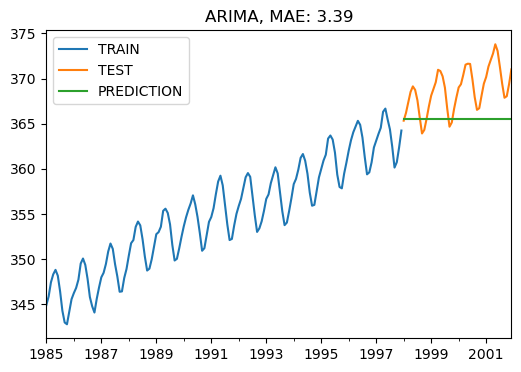

In [22]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

plot_co2(train, test, y_pred, "ARIMA")

### Hyperparameter Optimization (Model Derecelerini Belirleme)

### AIC & BIC İstatistiklerine Göre Model Derecesini Belirleme

In [25]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))


def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order).fit(disp=0)
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

best_params_aic = arima_optimizer_aic(train, pdq)

Best ARIMANone AIC=inf


### Final Model

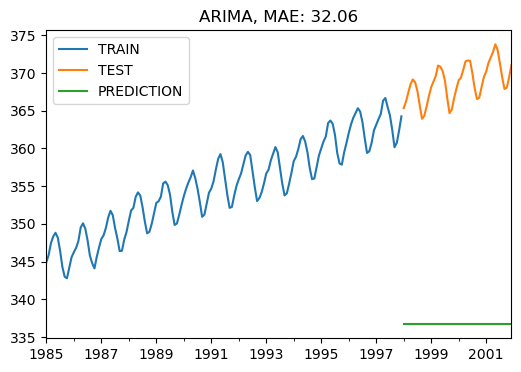

In [29]:
arima_model = ARIMA(train, best_params_aic).fit()
y_pred = arima_model.forecast(48)[0]

y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "ARIMA")

# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46501D+04    |proj g|=  2.06678D+05

At iterate    5    f=  3.81551D+02    |proj g|=  8.49262D+02

At iterate   10    f=  2.34942D+01    |proj g|=  3.11961D+01

At iterate   15    f=  3.59575D+00    |proj g|=  1.23039D+00

At iterate   20    f=  2.00282D+00    |proj g|=  1.10197D-01

At iterate   25    f=  1.51486D+00    |proj g|=  2.76392D-01

At iterate   30    f=  1.35075D+00    |proj g|=  1.68150D-02

At iterate   35    f=  1.32635D+00    |proj g|=  1.08813D-02

At iterate   40    f=  1.32360D+00    |proj g|=  1.44381D-03

At iterate   45    f=  1.32353D+00    |proj g|=  6.77960D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


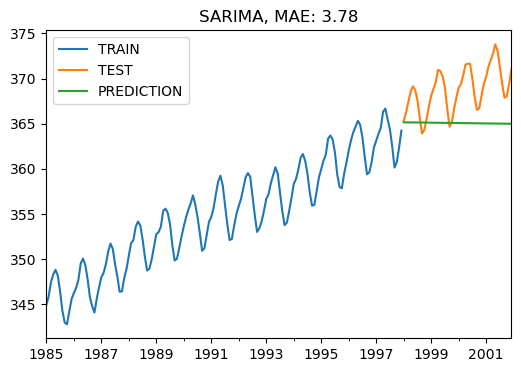

In [31]:
model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 12))

sarima_model = model.fit()

y_pred_test = sarima_model.get_forecast(steps=48)

y_pred = y_pred_test.predicted_mean

y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

### Hyperparameter Optimization (Model Derecelerini Belirleme)

In [33]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order

best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6922.606550808509
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6318.305219681431
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1643.9996657880488
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1428.2938925350809
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1911.7686774421127
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1623.2470778120855
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1205.0254009709297
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:973.2077276276001
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6269.190364739549
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5663.567927262488
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1229.8447515476919
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1499.7965866824566
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2033.0066409503638
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1008.1602685041174
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:767.633295491556
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1523.9134546907471
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1154.7436199042202
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:

### Final Model

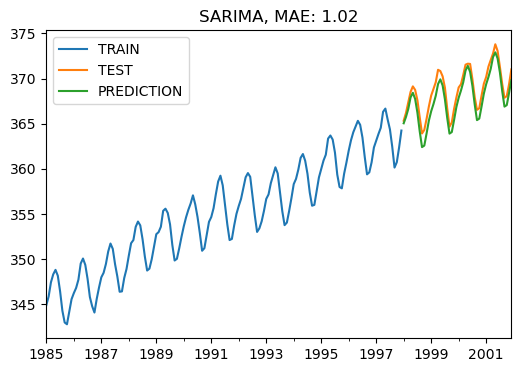

In [36]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

y_pred_test = sarima_final_model.get_forecast(steps=48)

y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

plot_co2(train, test, y_pred, "SARIMA")

# MAE'ye Göre SARIMA Optimizasyonu

In [38]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [39]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=48)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [40]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:368.7634375
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:324.17909156740615
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:5.063020833333329
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:4.803324370675553
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:5.161002785816309
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:4.846155232451147
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:3.3237251813650466
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:1.5279727769913052
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:364.9178691427658
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:320.4050598623678
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:4.985339409415236
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:4.765306186812539
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:4.990167874158526
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:5.029113019428887
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:3.6741581079165138
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1.566668235202015
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:4.526979166666664
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:3.9315401445

In [41]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15988D-01    |proj g|=  1.94259D-01

At iterate    5    f=  5.13993D-01    |proj g|=  8.36073D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   8.361D-06   5.140D-01
  F =  0.51399282933536117     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [42]:
y_pred_test = sarima_final_model.get_forecast(steps=48)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)

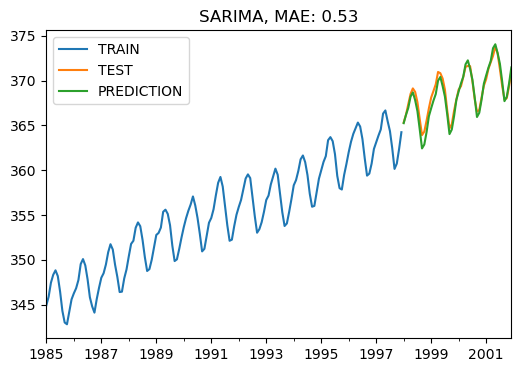

In [43]:
plot_co2(train, test, y_pred, "SARIMA")

### Final Model

In [46]:
model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)

feature_predict = sarima_final_model.get_forecast(steps=6)
feature_predict = feature_predict.predicted_mean

In [47]:
feature_predict

2002-01-01    371.930533
2002-02-01    372.718069
2002-03-01    373.585289
2002-04-01    374.494058
2002-05-01    375.101883
2002-06-01    374.687873
Freq: MS, Name: predicted_mean, dtype: float64